In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pathlib import Path
import seaborn as sns

%matplotlib inline

In [3]:
# Import CSV file of ETFs

etf_df = pd.read_csv('ETF prices.csv', parse_dates=True, infer_datetime_format=True)

In [4]:
# Drop unneeded columns from DataFrame

etf_df.drop(columns=['open', 'high', 'low', 'close', 'volume'], inplace=True)

In [5]:
# Create dataframe table with data starting from 2016

etf_2016 = etf_df.loc[etf_df['price_date'] >= "2016"]

In [7]:
# Create pivot table that displays the prices of each ETF by date

etf_pivot = etf_2016.pivot_table(index = ["price_date"], columns = "fund_symbol", values = "adj_close")

In [10]:
# Remove ETFs that don't have a full data sample over entire 5-year period

etf_pivot_df = etf_pivot.dropna(axis='columns')

In [12]:
#Find the daily returns of each ETF

etf_returns = etf_pivot_df.pct_change().dropna()

In [72]:
# Import CSV file of 10-year Treasury rates data

tnx_df = pd.read_csv("^TNX.csv", parse_dates=True, infer_datetime_format=True)

In [76]:
# Set df index

tnx_index = tnx_df.set_index("Date")

In [81]:
# Drop irrelevant columns

tnx_index.drop(columns=['Open', "High", "Low", "Close", "Volume"], inplace=True)

In [82]:
# Drop Null Values

tnx_df.dropna(inplace=True)

In [83]:
# Concatenate TNX df with ETF df

tnx_etf = pd.concat([tnx_index, etf_pivot_df], join = "inner", axis = 1)

In [86]:
# Rename TNX column

tnx_etf.rename(columns={"Adj Close" : "TNX"}, inplace=True)

In [90]:
# Find daily returns of Dataframe and drop null values

tnx_etf_returns = tnx_etf.pct_change().dropna()

In [98]:
# Find sharpe ratio of each ETF

sharpe_ratio = ((tnx_etf_returns.mean()-tnx_etf_returns['TNX'].mean()) * 252)/(tnx_etf_returns.std() * np.sqrt(252))

In [105]:
sharpe_ratio.describe()

count    1072.000000
mean       -0.234428
std         1.708128
min       -33.753087
25%        -0.295856
50%         0.072202
75%         0.295121
max         1.066480
dtype: float64

<AxesSubplot:>

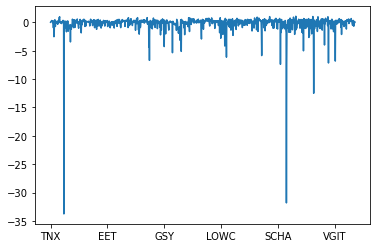

In [104]:
sharpe_ratio.plot()

In [108]:
# Import ETF CSV

etf_desc = pd.read_csv("ETFs.csv")

In [110]:
# Match etfs with etfs that contain 5 years of data

etf_matched = etf_desc[etf_desc.fund_symbol.isin(tnx_etf_returns.columns)]

In [164]:
# Drop leveraged ETFs

dropped = etf_matched[etf_matched["fund_category"].str.contains("Leveraged")==False]

In [169]:
# Drop Ultrashort ETFs

ultra_etf = dropped[dropped['fund_category'].str.contains("Ultrashort")==False]

In [189]:
# Drop Inverse ETFs and Display total ETF selection

final_etf = ultra_etf[ultra_etf['fund_category'].str.contains("Inverse")==False]

In [195]:
# Factor out Bond ETFs from Equity ETFs

bond_etfs = final_etf[final_etf.fund_category.str.contains('Bond', na=False)]

In [203]:
# Factor out Equity ETFs from Bond ETFs

equity_etfs = final_etf[final_etf["fund_category"].str.contains('Bond')==False]

In [251]:
# Factor out Foreign from Domestic Equities

foreign_equity = equity_etfs[(equity_etfs.fund_category.str.contains('Foreign') | (equity_etfs.fund_category.str.contains('Pacific/Asia ex-Japan Stk'))| (equity_etfs.fund_category.str.contains('Emerging'))
            | (equity_etfs.fund_category.str.contains('China')) | (equity_etfs.fund_category.str.contains('Latin')) | (equity_etfs.fund_category.str.contains('Europe')) | (equity_etfs.fund_category.str.contains('Japan')) |
                             (equity_etfs.fund_category.str.contains('India'))]

In [254]:
# Factor out Real Estate ETFs

real_estate_etfs = equity_etfs[equity_etfs.fund_category.str.contains("Real Estate")]

In [300]:
# Filter equities by betas

equity_beta = equity_etfs[['fund_symbol', 'fund_beta_5years']]

In [303]:
# Filter out highly negative betas

equity_etf_beta = equity_beta[equity_beta.fund_beta_5years > -4]

In [394]:
equity_beta

,fund_symbol,fund_beta_5years
1,AADR,1.11
2,AAXJ,0.94
10,ACWX,1.00
13,ADRE,1.10
17,AFK,1.19
...,...,...
2305,EPP,1.07
2306,ERUS,1.19
2307,EWA,1.16
2308,EWC,1.10


In [325]:
# Create df of lower beta ETFs

low_beta = equity_beta[(equity_beta.fund_beta_5years > 0) & (equity_beta.fund_beta_5years < 0.5)]

In [326]:
# Create df of low to medium beta ETFs

low_medium_beta = equity_beta[(equity_beta.fund_beta_5years > 0.51) & (equity_beta.fund_beta_5years < 1.00)]

In [317]:
# Create df of medium level beta ETFs

medium_beta = equity_beta[(equity_beta.fund_beta_5years > 1.001) & (equity_beta.fund_beta_5years < 1.5)]

In [322]:
# Create df of medium to high ETFs

high_medium_beta = equity_beta[(equity_beta.fund_beta_5years > 1.25) & (equity_beta.fund_beta_5years < 1.75)]

In [327]:
# Create df of high beta ETFs

high_beta = equity_beta[(equity_beta.fund_beta_5years > 1.76) & (equity_beta.fund_beta_5years < 5)]

In [333]:
# Risk Tolerances (by basket)

1 - 40%, 30%, 20%, 5%, 5%
2 - 20%, 40%, 20%, 10%, 10%
3 - 10%, 20%, 40%, 20%, 10%
4 - 10%, 10%, 20%, 40%, 20%
5 - 5%, 5%, 20%, 30%, 40%

In [373]:
# Find bond investment grade qualities

bond_quality = bond_etfs[['fund_symbol', 'fund_bonds_aaa', 'fund_bonds_aa', 'fund_bonds_a', 'fund_bonds_bbb', 
          'fund_bonds_bb', 'fund_bonds_b', 'fund_bonds_below_b']]

In [378]:
# Drop NaN's

bond_quality = bond_quality.dropna()

In [363]:
# Find what percent of bond ETFs are investment grade

investment_percent = bond_quality['fund_bonds_aaa'] + bond_quality['fund_bonds_aa'] + bond_quality['fund_bonds_a']

In [387]:
# Find what percent of bond ETFs are mid-investment grade

mid_investment = bond_quality['fund_bonds_bbb'] 

In [388]:
# Find what percent of bond ETFs are non-investment grade

noninvest_percent = bond_quality['fund_bonds_bb'] + bond_quality['fund_bonds_b']

In [389]:
# Add column to df

bond_quality["Investment Grade Percent"] = investment_percent

/var/folders/xf/5gg0rlzs2xlbl_dwfhdrq43h0000gn/T/ipykernel_11455/3901423594.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_quality["Investment Grade Percent"] = investment_percent


In [392]:
bond_quality['Mid Investment Grade'] = mid_investment

/var/folders/xf/5gg0rlzs2xlbl_dwfhdrq43h0000gn/T/ipykernel_11455/2863926551.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_quality['Mid Investment Grade'] = mid_investment


In [390]:
# Add column to df

bond_quality["Non-Invest Grade Percent"] = noninvest_percent

/var/folders/xf/5gg0rlzs2xlbl_dwfhdrq43h0000gn/T/ipykernel_11455/1515454792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bond_quality["Non-Invest Grade Percent"] = noninvest_percent


In [393]:
bond_quality

,fund_symbol,fund_bonds_aaa,fund_bonds_aa,fund_bonds_a,fund_bonds_bbb,fund_bonds_bb,fund_bonds_b,fund_bonds_below_b,Investment Grade Percent,Non-Invest Grade Percent,Mid Investment Grade
45,ANGL,0.0064,0.0000,0.0000,0.0000,0.9340,0.0399,0.0197,0.0064,0.9739,0.0000
130,BIV,0.5451,0.0310,0.1697,0.2524,0.0000,0.0000,0.0003,0.7458,0.0000,0.2524
151,BLV,0.4106,0.0619,0.2138,0.3137,0.0000,0.0000,0.0000,0.6863,0.0000,0.3137
155,BND,0.6872,0.0334,0.1187,0.1617,0.0000,0.0000,0.0001,0.8393,0.0000,0.1617
186,BSJN,0.0349,0.0000,0.0000,0.0000,0.5852,0.2908,0.0891,0.0349,0.8760,0.0000
...,...,...,...,...,...,...,...,...,...,...,...
2157,HYG,0.0028,0.0000,0.0000,0.0061,0.5653,0.3127,0.1140,0.0028,0.8780,0.0061
2158,HYGH,0.0090,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090,0.0000,0.0000
2159,HYXU,0.0004,0.0000,0.0000,0.0033,0.6986,0.2194,0.0707,0.0004,0.9180,0.0033
2207,IGBH,0.0298,0.1139,0.3569,0.4994,0.0000,0.0000,0.0000,0.5006,0.0000,0.4994


In [ ]:
# Real Estate Yes

20% real estate, x% Equity, y% bonds

# Foreign Yes

20% foreign, x% equity, y% bonds

# Real estate yes foreign yes

15% foreign, 15% real estate, x% equity, y% bonds

In [395]:
real_estate_etfs

,fund_symbol,quote_type,region,fund_short_name,fund_long_name,currency,fund_category,fund_family,exchange_code,exchange_name,...,fund_stdev_5years,fund_sharpe_ratio_5years,fund_treynor_ratio_5years,fund_alpha_10years,fund_beta_10years,fund_mean_annual_return_10years,fund_r_squared_10years,fund_stdev_10years,fund_sharpe_ratio_10years,fund_treynor_ratio_10years
396,DRW,ETF,US,American Century Disciplined Gr,American Century Disciplined Growth Fund Class R,USD,Global Real Estate,American Century Investments,PCX,NYSEArca,...,16.66,0.34,4.44,-4.52,1.01,0.51,70.85,16.91,0.32,4.05
551,EWRE,ETF,US,Global Small Cap Fund - Investo,American Century Global Small Cap Fund Investo...,USD,Real Estate,American Century Investments,PCX,NYSEArca,...,17.28,0.52,8.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN
614,FFR,ETF,US,American Funds Global Insight F,American Funds Global Insight Fund Class F-1,USD,Global Real Estate,American Funds,PCX,NYSEArca,...,16.16,0.32,4.42,-1.75,0.88,0.63,63.27,15.56,0.44,6.66
730,FREL,ETF,US,American Funds International Va,American Funds International Vantage Fund Clas...,USD,Real Estate,American Funds,PCX,NYSEArca,...,15.72,0.52,8.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
731,FRI,ETF,US,American Funds International Va,American Funds International Vantage Fund Clas...,USD,Real Estate,American Funds,PCX,NYSEArca,...,16.84,0.34,5.18,1.39,0.78,0.81,44.42,16.54,0.55,10.27
837,GQRE,ETF,US,"The Income Fund of America, Cla",American Funds The Income Fund of America Clas...,USD,Global Real Estate,American Funds,PCX,NYSEArca,...,15.45,0.32,4.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
972,IFGL,ETF,US,NaN,Angel Oak Core Impact Fund Institutional Class,USD,Global Real Estate,Angel Oak,NGM,NasdaqGM,...,16.01,0.35,4.71,-4.11,0.97,0.50,71.42,16.12,0.34,4.35
1131,KBWY,ETF,US,One Choice 2060 Portfolio - R6,American Century Investments One Choice 2060 P...,USD,Real Estate,American Century Investments,NGM,NasdaqGM,...,27.04,0.08,-1.40,-3.55,1.13,0.68,49.25,22.58,0.34,4.40
1254,MORT,ETF,US,Invesco Asian Pacific Growth Fu,Invesco Asia Pacific Growth Fund Class C,USD,Real Estate,Invesco,PCX,NYSEArca,...,31.30,0.39,3.59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1527,RDOG,ETF,US,"BlackRock Fds, All-Cap Energy &",BlackRock Energy Opportunities Fund Investor A...,USD,Real Estate,BlackRock,PCX,NYSEArca,...,20.08,0.31,3.80,-2.50,1.00,0.67,62.10,17.91,0.41,5.91
